# Import Libraries

In [83]:
# prerequisites
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda, concatenate
from keras.models import Model
from keras import backend as K
from keras import objectives
from tensorflow.keras.utils import to_categorical
from scipy.stats import norm

# Preprocess

In [84]:
# data load
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr, x_te = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)
print(x_tr.shape, x_te.shape)

# one-hot encoding
y_tr, y_te = to_categorical(y_tr), to_categorical(y_te)
print(y_tr.shape, y_te.shape)

# network parameters
batch_size, n_epoch = 50, 10
n_hidden, z_dim = 512, 2

(60000, 784) (10000, 784)
(60000, 10) (10000, 10)


# Encoding Layer

In [85]:
# encoder
x = Input(shape=(x_tr.shape[1:]))
condition = Input(shape=(y_tr.shape[1],))

inputs = concatenate([x, condition])
x_encoded = Dense(n_hidden, activation='relu')(inputs)
x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)
mu = Dense(z_dim, activation='linear')(x_encoded)
log_var = Dense(z_dim, activation='linear')(x_encoded)

# Sampling in Latent Space

In [86]:
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var/2.) * eps

z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])
z_cond = concatenate([z, condition])


# Decoding Layer

In [87]:
# decoder
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr.shape[1], activation='sigmoid')

z_decoded = z_decoder1(z_cond)
z_decoded = z_decoder2(z_decoded)
y = y_decoder(z_decoded)

# Loss Function & Complining

In [88]:
# loss
reconstruction_loss = objectives.binary_crossentropy(x, y) * x_tr.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
cvae_loss = reconstruction_loss + kl_loss

# build model
cvae = Model([x, condition], y)
cvae.add_loss(cvae_loss)
cvae.compile(optimizer='adam')
cvae.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 794)          0           input_16[0][0]                   
                                                                 input_17[0][0]                   
__________________________________________________________________________________________________
dense_35 (Dense)                (None, 512)          407040      concatenate_10[0][0]      

# Save Models

In [89]:
# from keras.callbacks import ModelCheckpoint
# checkpoint = ModelCheckpoint(filepath='model{epoch:01d}.ckpt', save_freq=1200, verbose = 1, save_best_only = False, save_weights_only=True)

In [90]:
n_epoch=10

In [91]:
# train
history=cvae.fit([x_tr, y_tr],                     ##       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=([x_te, y_te], None), verbose=1) #,callbacks = [checkpoint]

Epoch 1/10
1200/1200 [==============================] - 5s 4ms/step - loss: 179.6140 - val_loss: 138.9075
Epoch 2/10
1200/1200 [==============================] - 4s 3ms/step - loss: 138.1165 - val_loss: 135.1114
Epoch 3/10
1200/1200 [==============================] - 4s 3ms/step - loss: 134.5068 - val_loss: 133.3830
Epoch 4/10
1200/1200 [==============================] - 4s 3ms/step - loss: 132.7790 - val_loss: 132.5504
Epoch 5/10
1200/1200 [==============================] - 4s 3ms/step - loss: 131.7666 - val_loss: 131.8200
Epoch 6/10
1200/1200 [==============================] - 4s 3ms/step - loss: 131.4723 - val_loss: 131.5453
Epoch 7/10
1200/1200 [==============================] - 4s 3ms/step - loss: 130.7768 - val_loss: 131.2457
Epoch 8/10
1200/1200 [==============================] - 4s 3ms/step - loss: 130.0748 - val_loss: 130.7776
Epoch 9/10
1200/1200 [==============================] - 4s 3ms/step - loss: 129.6482 - val_loss: 130.4311
Epoch 10/10
1200/1200 [=======================

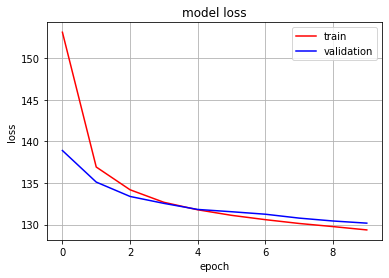

In [92]:
### Plot the Loss Curves
fig = plt.figure()
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()

# Latent Space

In [93]:
# build encoder
encoder = Model([x, condition], mu)
encoder.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 794)          0           input_16[0][0]                   
                                                                 input_17[0][0]                   
__________________________________________________________________________________________________
dense_35 (Dense)                (None, 512)          407040      concatenate_10[0][0]      

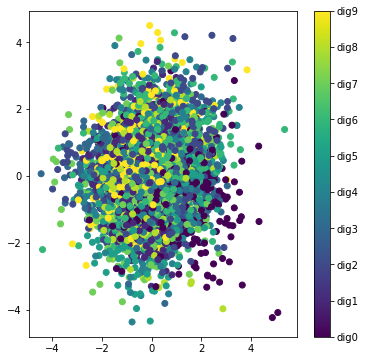

In [94]:
# Plot of the digit classes in the latent space
classes=10
zones=(['dig0','dig1','dig2','dig3','dig4','dig5','dig6','dig7','dig8','dig9'])

te_latent = encoder.predict([x_te, y_te], batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(te_latent[:, 0], te_latent[:, 1], c=np.argmax(y_te, axis=1))
plt.colorbar(ticks=range(classes)).set_ticklabels(zones)
plt.show()

In [95]:
# build decoder
decoder_input = Input(shape=(z_dim+y_tr.shape[1],))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_y = y_decoder(_z_decoded)
generator = Model(decoder_input, _y)
generator.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 12)]              0         
_________________________________________________________________
dense_39 (Dense)             multiple                  3328      
_________________________________________________________________
dense_40 (Dense)             multiple                  131584    
_________________________________________________________________
dense_41 (Dense)             multiple                  402192    
Total params: 537,104
Trainable params: 537,104
Non-trainable params: 0
_________________________________________________________________


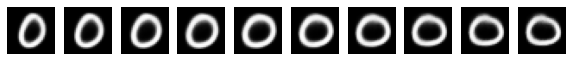

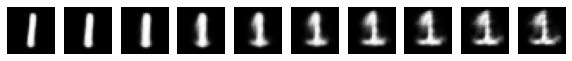

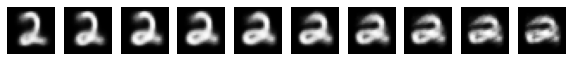

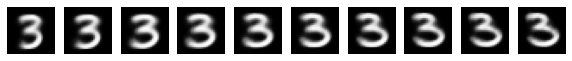

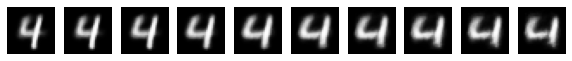

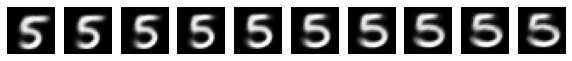

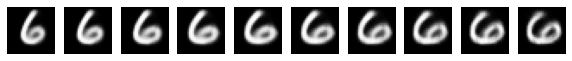

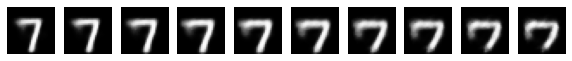

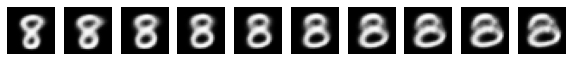

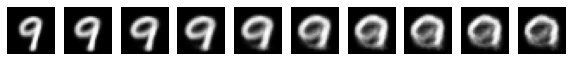

In [96]:
# exploring the latent space: change z sample on the x-axis
digit_size = 28
for cond_num in range(10):
    condition_num = to_categorical(cond_num, 10).reshape(1,-1)
    plt.figure(figsize=(10, 2))

    for i in range(10):
        z_sample = np.array([[0.3*i, 0.3]])
        x_decoded = generator.predict(np.column_stack([z_sample, condition_num]))
        digit = x_decoded[0].reshape(digit_size, digit_size)

        plt.subplot(1, 10, i+1)
        plt.axis('off')
        plt.imshow(digit, cmap='Greys_r',)

plt.show()

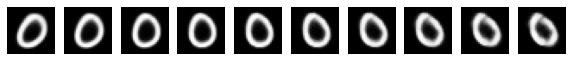

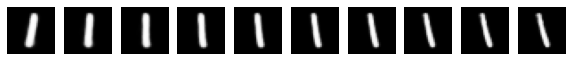

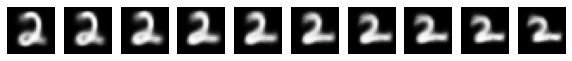

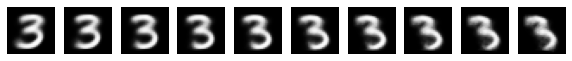

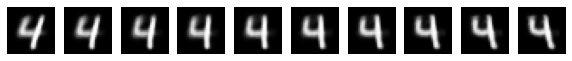

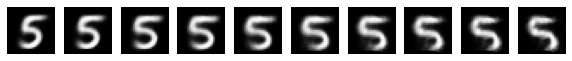

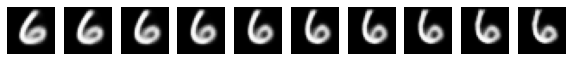

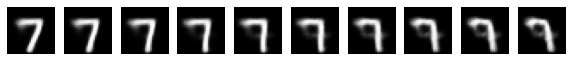

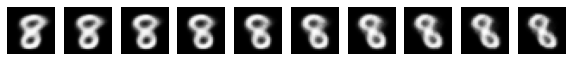

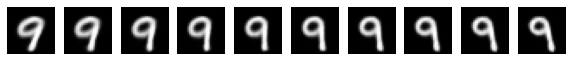

In [97]:
# exploring the latent space: change z sample on the y-axis
digit_size = 28
for cond_num in range(10):
    condition_num = to_categorical(cond_num, 10).reshape(1,-1)
    plt.figure(figsize=(10, 2))

    for i in range(10):
        z_sample = np.array([[0.3, 0.3*i]])
        x_decoded = generator.predict(np.column_stack([z_sample, condition_num]))
        digit = x_decoded[0].reshape(digit_size, digit_size)

        plt.subplot(1, 10, i+1)
        plt.axis('off')
        plt.imshow(digit, cmap='Greys_r',)

plt.show()

# Original & Generated Images

Real Test Images


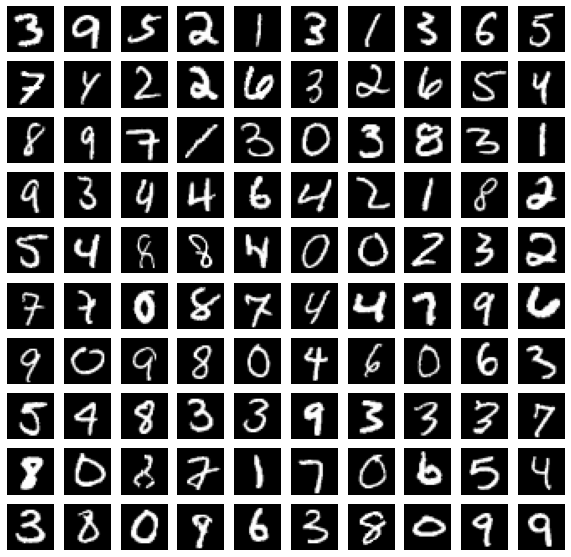

Reconstructed Images with Variational Autoencoder


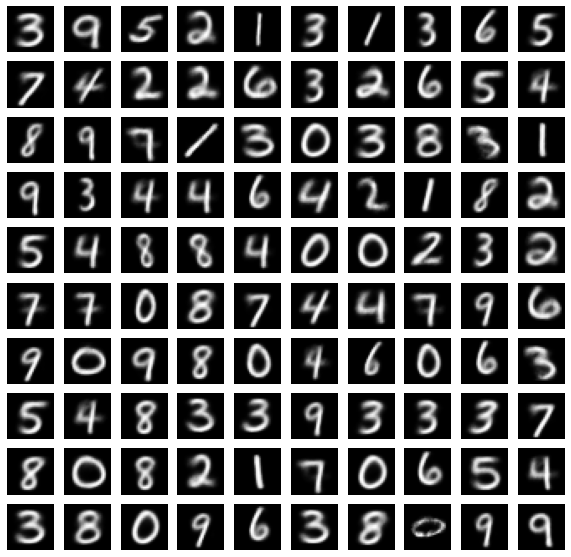

In [98]:
offset=500
print ("Real Test Images")
fig1 = plt.figure(figsize=(10,10))
# Real Images
for i in range(10):
  for j in range(10):
    plt.subplot(10,10,i+j*10+1, frameon=False)
    # plt.imshow(test_data[i+j*10+offset,:,:, -1], cmap='gray')
    plt.imshow(x_te[i+j*10+offset,:].reshape((28,28)), cmap='gray')
    plt.axis('off')
plt.show()


##1
# Reconstructed Images
print ("Reconstructed Images with Variational Autoencoder")
fig1 = plt.figure(figsize=(10,10))
for i in range(10):
  for j in range(10):
    plt.subplot(10,10,i+j*10+1, frameon=False)
    # output = model1.predict(np.array([test_data[i+j*10+offset]]))
    output = generator.predict(np.column_stack([te_latent[i+j*10+offset,:].reshape((1,2)), y_te[i+j*10+offset,:].reshape((1,10))]))
    op_image = np.reshape(output[0]*255, (28, 28))
    plt.imshow(op_image, cmap='gray')
    plt.axis('off')
plt.show()